# Fourier Feature Mapping on PytorchLightening with Gabor

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from turboflow.utils import physics as phy

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from turboflow.dataloaders import DataModule

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Input data

Warning *** CHECK THE GRADIENT DIRECTION


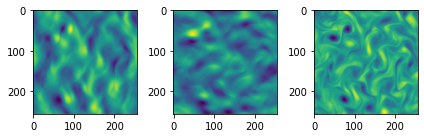

In [2]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2]
V = IMGs[img_index,:,:,3]

W = phy.compute_vorticity(U,V)

plt.subplot(131)
plt.imshow(U)
plt.subplot(132)
plt.imshow(V)
plt.subplot(133)
plt.imshow(W)
plt.tight_layout()
plt.show()

In [3]:
# normalize output
y = U[:,:,None]
print(np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print(np.min(y), np.max(y))

assert np.max(np.abs(y)) <= 1.0
assert np.max(np.abs(X)) <= 1.0

-2.382122 2.535017
-0.9396867949997968 1.0


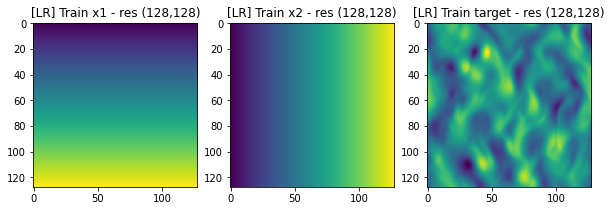

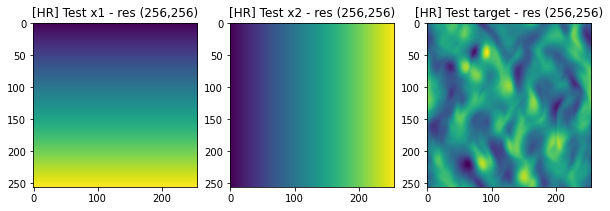

In [4]:
inputs = 2*X-1
labels = y

# downsampled resultion (one every 2)
ds = 2
Xtrain = inputs[::ds,::ds,:]
ytrain = labels[::ds,::ds]
Xtest = inputs
ytest = labels

plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[LR] Train x1 - res (%d,%d)' % Xtrain[:,:,0].shape)
plt.imshow(Xtrain[:,:,0])
plt.subplot(132)
plt.title('[LR] Train x2 - res (%d,%d)' % Xtrain[:,:,1].shape)
plt.imshow(Xtrain[:,:,1])
plt.subplot(133)
plt.title('[LR] Train target - res (%d,%d)' % ytrain[:,:,0].shape)
plt.imshow(ytrain)
plt.show()

plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[HR] Test x1 - res (%d,%d)' % Xtest[:,:,0].shape)
plt.imshow(Xtest[:,:,0])
plt.subplot(132)
plt.title('[HR] Test x2 - res (%d,%d)' % Xtest[:,:,1].shape)
plt.imshow(Xtest[:,:,1])
plt.subplot(133)
plt.title('[HR] Test target - res (%d,%d)' % ytest[:,:,0].shape)
plt.imshow(ytest)
plt.show()

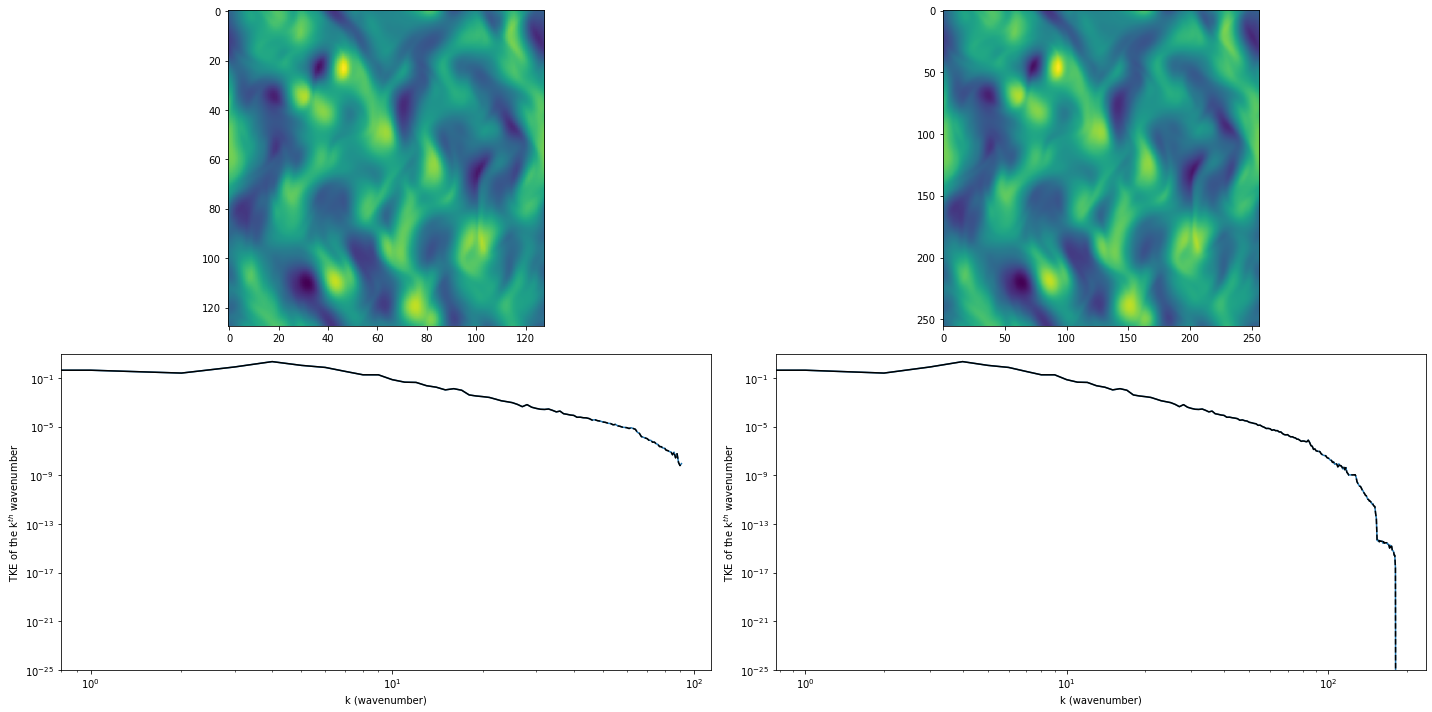

In [5]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0,0].imshow(ytrain)
axs[0,1].imshow(ytest)
phy.plot_energy_spec(phy.powerspec(ytrain), axs[1,0])
phy.plot_energy_spec(phy.powerspec(ytest), axs[1,1])
plt.tight_layout()
plt.show()

## Fourier Features Mapping

In [6]:
def fourier_features(X, freqs):
    rFFM = X @ freqs.T
    return np.concatenate([np.cos(rFFM), np.sin(rFFM)], axis=-1)

# random Gabor Feature mapping
def gabor_features(X, freqs, sigmas_sqr, offsets=None):
    if offsets is None:
        assert sigmas_sqr.shape[-1] == freqs.shape[-1] == X.shape[-1] == 2
        scales = 1 / (2*np.pi*np.sqrt(sigmas_sqr[:,0]*sigmas_sqr[:,1]))
        inv_scales = 1 / (sigmas_sqr)
        scales = 1 # for normalization
        gauss = scales*np.exp(-0.5*((X**2) @ inv_scales.T))
        sines = X @ freqs.T
    else:
        assert sigmas_sqr.shape[-1] == freqs.shape[-1] == X.shape[-1] == offsets.shape[-1] == 2
        scales = 1 / (2*np.pi*np.sqrt(sigmas_sqr[:,0]*sigmas_sqr[:,1]))
        inv_scales = 1 / (sigmas_sqr)
        scales = 1
        X = np.add(X[...,None], offsets.T)
        gauss = scales*np.exp(-0.5*(np.sum(X**2 * inv_scales.T, axis=2)))
        sines = np.sum(X * freqs.T, axis=2)
    return np.concatenate([gauss*np.cos(sines), gauss*np.sin(sines)], axis=-1)

Fourier (128, 128, 1024)
Gabor (128, 128, 1024)


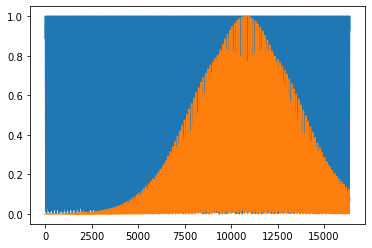

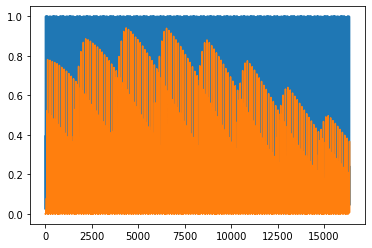

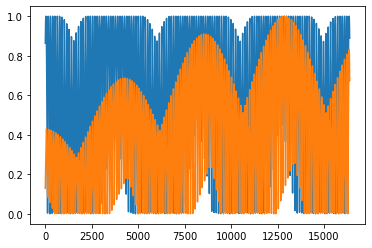

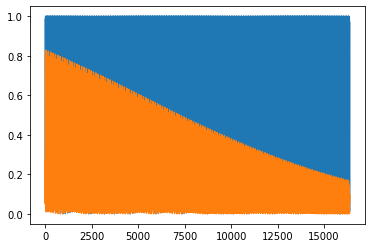

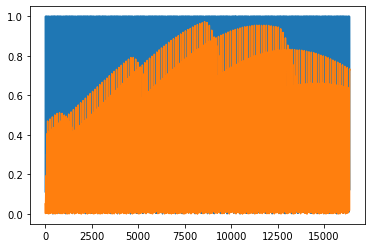

In [7]:
np.random.seed(666)

ndim = 2
nfeatures = 512

# random Fourier Feature mapping
B = np.random.normal(0, 10, size=(nfeatures, ndim))
S = np.abs(np.random.normal(0, 1, size=(nfeatures, ndim)))
O = np.random.normal(0, 1, size=(nfeatures, ndim))

rFFM = fourier_features(Xtrain, B)
print('Fourier', rFFM.shape)
rGFM = gabor_features(Xtrain, B, S, O)
print('Gabor', rGFM.shape)


# for f in range(nfeatures):
#     plt.subplot(121)
#     plt.imshow(rFFM[:,:,f])
#     plt.subplot(122)
#     plt.imshow(rGFM[:,:,f])
#     plt.show()

for f in range(5):
    plt.plot(np.abs(rFFM[:,:,f].flatten()))
    plt.plot(np.abs(rGFM[:,:,f].flatten()))
    plt.show()

## LEARNING TURBULENCES

In [24]:
dm_dict = {}

dm_dict['Fourier'] = DataModule(
    train_data=[fourier_features(Xtrain, B), ytrain],
    val_data=[fourier_features(Xtest, B), ytest],
    test_data =[fourier_features(Xtest, B), ytest]
)

dm_dict['Gabor'] = DataModule(
    train_data=[gabor_features(Xtrain, B, S, O), ytrain],
    val_data=[gabor_features(Xtest, B, S, O), ytest],
    test_data =[gabor_features(Xtest, B, S, O), ytest]
)

In [25]:
# test data loader
dm_dict['Fourier'].prepare_data()
for batch in dm_dict['Fourier'].train_dataloader():
    X, y = batch
    print(X.shape)
    print(y.shape)
    
dm_dict['Gabor'].prepare_data()
for batch in dm_dict['Gabor'].val_dataloader():
    X, y = batch
    print(X.shape)
    print(y.shape)

here
(128, 128, 1024)
(128, 128, 1)
here2
(256, 256, 1024)
(256, 256, 1)
(256, 256, 1024)
(256, 256, 1)
torch.Size([1, 128, 128, 1024])
torch.Size([1, 128, 128, 1])
here
(128, 128, 1024)
(128, 128, 1)
here2
(256, 256, 1024)
(256, 256, 1)
(256, 256, 1024)
(256, 256, 1)
torch.Size([1, 256, 256, 1024])
torch.Size([1, 256, 256, 1])


In [26]:
import torch.nn as nn
import torch.nn.functional as F

def create_blockReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

class MLP(pl.LightningModule):
    def __init__(self, layer_dimension):
        super().__init__()
        
        layers = []
        num_layers = len(layer_dimension)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(create_blockReLU(layer_dimension[l], layer_dimension[l+1]))
            
        blocks.append(nn.Linear(layer_dimension[-2], layer_dimension[-1]))
        blocks.append(nn.Tanh())
        
        self.mlp = nn.Sequential(*blocks)
    
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self.mlp(x) 
    
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        psnr = 10 * np.log(2*loss.item())
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        psnr = 10 * np.log(2*loss.item())
        self.log('valid_loss', loss, on_step=True)
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [27]:
layers = [1024] + 3*[256] + [1]
model_dict = {}

model_dict['Fourier'] = MLP(layers)
model_dict['Gabor'] = MLP(layers)

max_iters = int(5e3)
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['Fourier'], dm_dict['Fourier'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 394 K 
------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [28]:
early_stop_callback = EarlyStopping(monitor='valid_loss')
trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])
trainer.fit(model_dict['Gabor'], dm_dict['Gabor'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 394 K 
------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.577     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

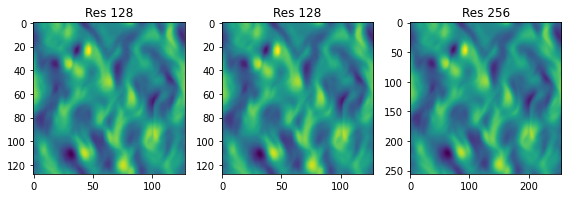

In [29]:
def my_pred(ngrid, model, input_features):
    model.eval().to(device)
    coords = np.linspace(-1, 1, ngrid, endpoint=False)
    coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
    tmp = coords[:,:,0].copy()
    coords[:,:,0] = coords[:,:,1]
    coords[:,:,1] = tmp
    if input_features == 'Fourier':
        features = fourier_features(coords, B)
    if input_features == 'Gabor':
        features = gabor_features(coords, B, S, O)
    pred = model(torch.from_numpy(features).float().to(device))
    ypred = pred.cpu().detach().numpy().squeeze()
    return ypred

Fpred = my_pred(128, model_dict['Fourier'], 'Fourier')
Gpred = my_pred(128, model_dict['Gabor'], 'Gabor')

figsize = (8,4)
fig, axs = plt.subplots(1, 3, figsize=figsize)
axs[0].imshow(Fpred)
axs[0].set_title('Res %d' % (Fpred.shape[0]))
axs[1].imshow(Gpred.squeeze())
axs[1].set_title('Res %d' % (Gpred.shape[0]))
axs[2].imshow(ytest.squeeze())
axs[2].set_title('Res %d' % (ytest.shape[0]))
plt.tight_layout()
plt.show()

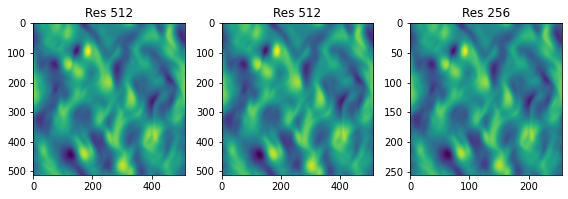

In [30]:
Fpred = my_pred(512, model_dict['Fourier'], 'Fourier')
Gpred = my_pred(512, model_dict['Gabor'], 'Gabor')

figsize = (8,4)
fig, axs = plt.subplots(1, 3, figsize=figsize)
axs[0].imshow(Fpred)
axs[0].set_title('Res %d' % (Fpred.shape[0]))
axs[1].imshow(Gpred.squeeze())
axs[1].set_title('Res %d' % (Gpred.shape[0]))
axs[2].imshow(ytest.squeeze())
axs[2].set_title('Res %d' % (ytest.shape[0]))
plt.tight_layout()
plt.show()

In [ ]:
# Fpred = my_pred(1024, model_dict['Fourier'], 'Fourier')
# Gpred = my_pred(1024, model_dict['Gabor'], 'Gabor')

# figsize = (8,4)
# fig, axs = plt.subplots(1, 3, figsize=figsize)
# axs[0].imshow(Fpred)
# axs[0].set_title('Res %d' % (Fpred.shape[0]))
# axs[1].imshow(Gpred.squeeze())
# axs[1].set_title('Res %d' % (Gpred.shape[0]))
# axs[2].imshow(ytest.squeeze())
# axs[2].set_title('Res %d' % (ytest.shape[0]))
# plt.tight_layout()
# plt.show()

(1024, 1024)


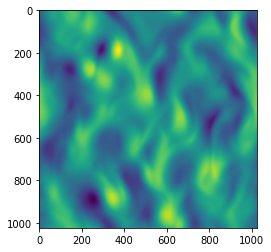

In [31]:
from scipy import interpolate

xx, yy = Xtrain[:,:,0], Xtrain[:,:,1]
x = np.linspace(-1,1,ytrain.shape[0])
y = np.linspace(-1,1,ytrain.shape[1])
z = ytrain

f_interp2d = interpolate.interp2d(x, y, z, kind='linear') # 'cubic'

x = np.linspace(-1,1,512)
y = np.linspace(-1,1,512)
Ipred = f_interp2d(x, y)
print(Ipred.shape)

plt.imshow(Ipred)
plt.show()

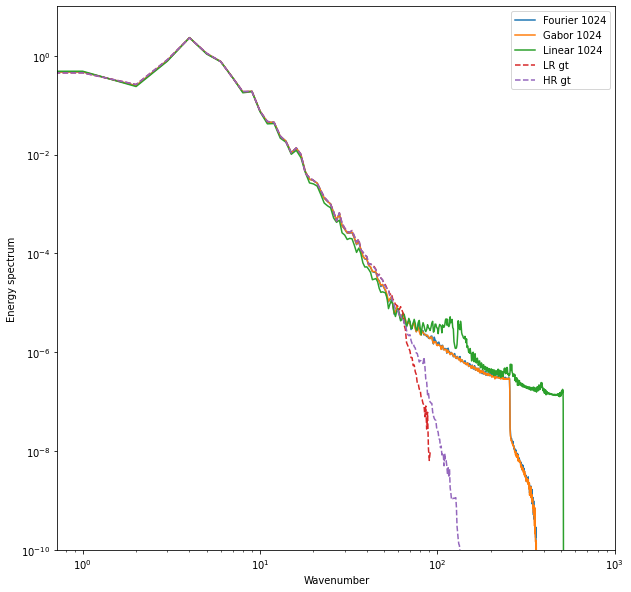

In [33]:
fig, axs = plt.subplots(figsize=(10,10))

plt.loglog(phy.powerspec(Fpred), label='Fourier 1024')
plt.loglog(phy.powerspec(Gpred), label='Gabor 1024')
plt.loglog(phy.powerspec(Ipred), label='Linear 1024')
plt.loglog(phy.powerspec(ytrain), '--', label='LR gt')
plt.loglog(phy.powerspec(ytest), '--', label='HR gt')
plt.ylim([10**-10,10])
plt.ylabel('Energy spectrum')
plt.xlabel('Wavenumber')
plt.legend()
plt.show()